# Importing Libraries

In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [2]:
import bz2
import os

from urllib.request import urlopen

def download_landmarks(dst_file):
    url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    decompressor = bz2.BZ2Decompressor()
    
    with urlopen(url) as src, open(dst_file, 'wb') as dst:
        data = src.read(1024)
        while len(data) > 0:
            dst.write(decompressor.decompress(data))
            data = src.read(1024)

dst_dir = 'models'
dst_file = os.path.join(dst_dir, 'landmarks.dat')

if not os.path.exists(dst_file):
    os.makedirs(dst_dir)
    download_landmarks(dst_file)

In [3]:
from tensorflow.keras import backend as K
import pickle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Layer
from tensorflow.keras import layers, models
from data import triplet_generator
import numpy as np
import os.path
from model import create_model
import pandas as pd
import tensorflow.keras.backend as K
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from align import AlignDlib
from sklearn.metrics import f1_score, accuracy_score
%matplotlib inline

# Importing Dataset

In [4]:
nn4_small2 = create_model()

In [5]:
# Input for anchor, positive and negative images
in_a = Input(shape=(96, 96, 3))
in_p = Input(shape=(96, 96, 3))
in_n = Input(shape=(96, 96, 3))

# Output for anchor, positive and negative embedding vectors
# The nn4_small model instance is shared (Siamese network)
emb_a = nn4_small2(in_a)
emb_p = nn4_small2(in_p)
emb_n = nn4_small2(in_n)

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

# Model that can be trained with anchor, positive negative images
nn4_small2_train = Model([in_a, in_p, in_n], triplet_loss_layer)

In [6]:
generator = triplet_generator() 
nn4_small2_train.compile(loss=None, optimizer='adam')
nn4_small2_train.fit(generator, epochs=10, steps_per_epoch=100)

Epoch 1/10
100/100 [==============================] - 8s 28ms/step - loss: 0.8090
Epoch 2/10
100/100 [==============================] - 3s 28ms/step - loss: 0.8058
Epoch 3/10
100/100 [==============================] - 3s 28ms/step - loss: 0.7997
Epoch 4/10
100/100 [==============================] - 3s 28ms/step - loss: 0.8009
Epoch 5/10
100/100 [==============================] - 3s 28ms/step - loss: 0.8003
Epoch 6/10
100/100 [==============================] - 3s 27ms/step - loss: 0.8001
Epoch 7/10
100/100 [==============================] - 3s 28ms/step - loss: 0.8004
Epoch 8/10
100/100 [==============================] - 3s 29ms/step - loss: 0.8002
Epoch 9/10
100/100 [==============================] - 3s 29ms/step - loss: 0.8000
Epoch 10/10
100/100 [==============================] - 3s 28ms/step - loss: 0.7998


In [7]:
nn4_small2_pretrained = create_model()
nn4_small2_pretrained.load_weights('weights/nn4.small2.v1.h5')

In [8]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in sorted(os.listdir(path)):
        for f in sorted(os.listdir(os.path.join(path, i))):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('images')

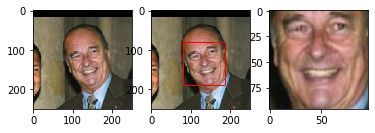

In [9]:
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

# Initialize the OpenFace face alignment utility
alignment = AlignDlib('models/landmarks.dat')

# Load an image of Jacques Chirac
jc_orig = load_image(metadata[77].image_path())

# Detect face and return bounding box
bb = alignment.getLargestFaceBoundingBox(jc_orig)

# Transform image using specified face landmark indices and crop image to 96x96
jc_aligned = alignment.align(96, jc_orig, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

# Show original image
plt.subplot(131)
plt.imshow(jc_orig)

# Show original image with bounding box
plt.subplot(132)
plt.imshow(jc_orig)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

# Show aligned image
plt.subplot(133)
plt.imshow(jc_aligned);

In [10]:
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

In [11]:
embedded = np.zeros((metadata.shape[0], 128))

for i, m in enumerate(metadata):
    img = load_image(m.image_path())
    img = align_image(img)
    # scale RGB values to interval [0,1]
    img = (img / 255.)#.astype(np.float32)
    # obtain embedding vector for image
    embedded[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]

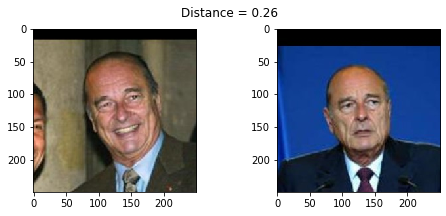

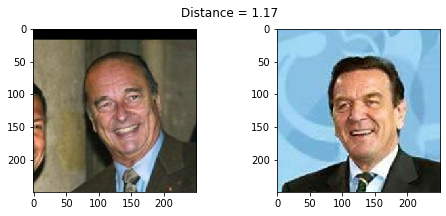

In [12]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(77, 78)
show_pair(77, 50)

# Applying Algorithms

In [13]:
targets = np.array([m.name for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)


y = encoder.transform(targets)

train_idx = np.arange(metadata.shape[0]) % 2 != 0
test_idx = np.arange(metadata.shape[0]) % 2 == 0


X_train = embedded[train_idx]

X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

# KNN

In [14]:
knn_model = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
knn_model.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=1)

In [15]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


y_pred_train = knn_model.predict(X_train)


y_pred_test = knn_model.predict(X_test)



accuracy_training = accuracy_score(y_train, y_pred_train)
precision_training = precision_score(y_train, y_pred_train, average='weighted')
recall_training = recall_score(y_train, y_pred_train, average='weighted')
f1_training = f1_score(y_train, y_pred_train, average='weighted')

print("Training Set Metrics:")
print(f"Accuracy: {accuracy_training:.4f}")
print(f"Precision: {precision_training:.4f}")
print(f"Recall: {recall_training:.4f}")
print(f"F1 Score: {f1_training:.4f}")

# Test Set
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')

print("\nTest Set Metrics:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1 Score: {f1_test:.4f}")



Training Set Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Test Set Metrics:
Accuracy: 0.9600
Precision: 0.9714
Recall: 0.9600
F1 Score: 0.9611


# SVM

In [16]:
svc = LinearSVC()
svc.fit(X_train, y_train)

LinearSVC()

In [17]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


y_pred_train = svc.predict(X_train)


y_pred_test = svc.predict(X_test)



accuracy_training1 = accuracy_score(y_train, y_pred_train)
precision_training1 = precision_score(y_train, y_pred_train, average='weighted')
recall_training1 = recall_score(y_train, y_pred_train, average='weighted')
f1_training1 = f1_score(y_train, y_pred_train, average='weighted')

print("Training Set Metrics:")
print(f"Accuracy: {accuracy_training1:.4f}")
print(f"Precision: {precision_training1:.4f}")
print(f"Recall: {recall_training1:.4f}")
print(f"F1 Score: {f1_training1:.4f}")

# Test Set
accuracy_test1 = accuracy_score(y_test, y_pred_test)
precision_test1 = precision_score(y_test, y_pred_test, average='weighted')
recall_test1 = recall_score(y_test, y_pred_test, average='weighted')
f1_test1 = f1_score(y_test, y_pred_test, average='weighted')

print("\nTest Set Metrics:")
print(f"Accuracy: {accuracy_test1:.4f}")
print(f"Precision: {precision_test1:.4f}")
print(f"Recall: {recall_test1:.4f}")
print(f"F1 Score: {f1_test1:.4f}")



Training Set Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Test Set Metrics:
Accuracy: 0.9800
Precision: 0.9833
Recall: 0.9800
F1 Score: 0.9798


# CNN

In [18]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [19]:
X_train_reshaped = X_train.reshape((-1, 128, 1))

model = models.Sequential()
model.add(layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(128, 1)))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Change to 'sigmoid' for binary classification


model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy', f1_score, recall_m, precision_m])  # Use 'binary_crossentropy' for binary classification


history = model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
2/2 [==============================] - 1s 137ms/step - loss: 0.5244 - accuracy: 0.0500 - f1_score: 0.9986 - recall_m: 0.9464 - precision_m: 1.0954 - val_loss: -1.9173 - val_accuracy: 0.0000e+00 - val_f1_score: 1.0000 - val_recall_m: 1.0000 - val_precision_m: 1.0000
Epoch 2/10
2/2 [==============================] - 0s 12ms/step - loss: -0.4571 - accuracy: 0.1250 - f1_score: 0.9333 - recall_m: 1.0000 - precision_m: 0.8750 - val_loss: -4.9885 - val_accuracy: 0.0000e+00 - val_f1_score: 1.0000 - val_recall_m: 1.0000 - val_precision_m: 1.0000
Epoch 3/10
2/2 [==============================] - 0s 12ms/step - loss: -1.5932 - accuracy: 0.1250 - f1_score: 0.9333 - recall_m: 1.0000 - precision_m: 0.8750 - val_loss: -8.7006 - val_accuracy: 0.0000e+00 - val_f1_score: 1.0000 - val_recall_m: 1.0000 - val_precision_m: 1.0000
Epoch 4/10
2/2 [==============================] - 0s 12ms/step - loss: -2.9765 - accuracy: 0.1250 - f1_score: 0.9040 - recall_m: 1.0000 - precision_m: 0.8281 - val_loss:

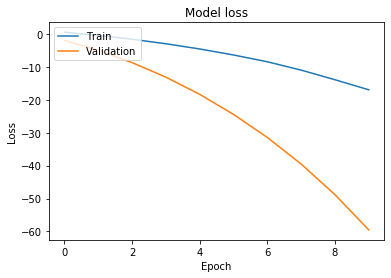

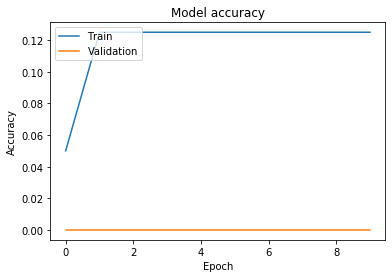

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [21]:
a = history.history['accuracy'][-1]
f = history.history['f1_score'][-1]
p = history.history['precision_m'][-1]
r = history.history['recall_m'][-1]

print('Accuracy = ' + str(a * 100))
print('Precision = ' + str(p * 100))
print('F1 Score = ' + str(f * 100))
print('Recall = ' + str(r * 100))

Accuracy = 12.5
Precision = 87.5
F1 Score = 93.33332777023315
Recall = 100.0


# Comparison

In [22]:

results = {
    'Accuracy': [accuracy_test,accuracy_test1,a],
    'Recall': [recall_test,recall_test1,r],
    'Precision': [precision_test,precision_test1,p],
    'F1': [f1_test,f1_test1,f]
}

index = ['KNN','SVM','CNN']

In [23]:
results =pd.DataFrame(results,index=index)
print(results)

     Accuracy  Recall  Precision        F1
KNN     0.960    0.96   0.971429  0.961111
SVM     0.980    0.98   0.983333  0.979798
CNN     0.125    1.00   0.875000  0.933333


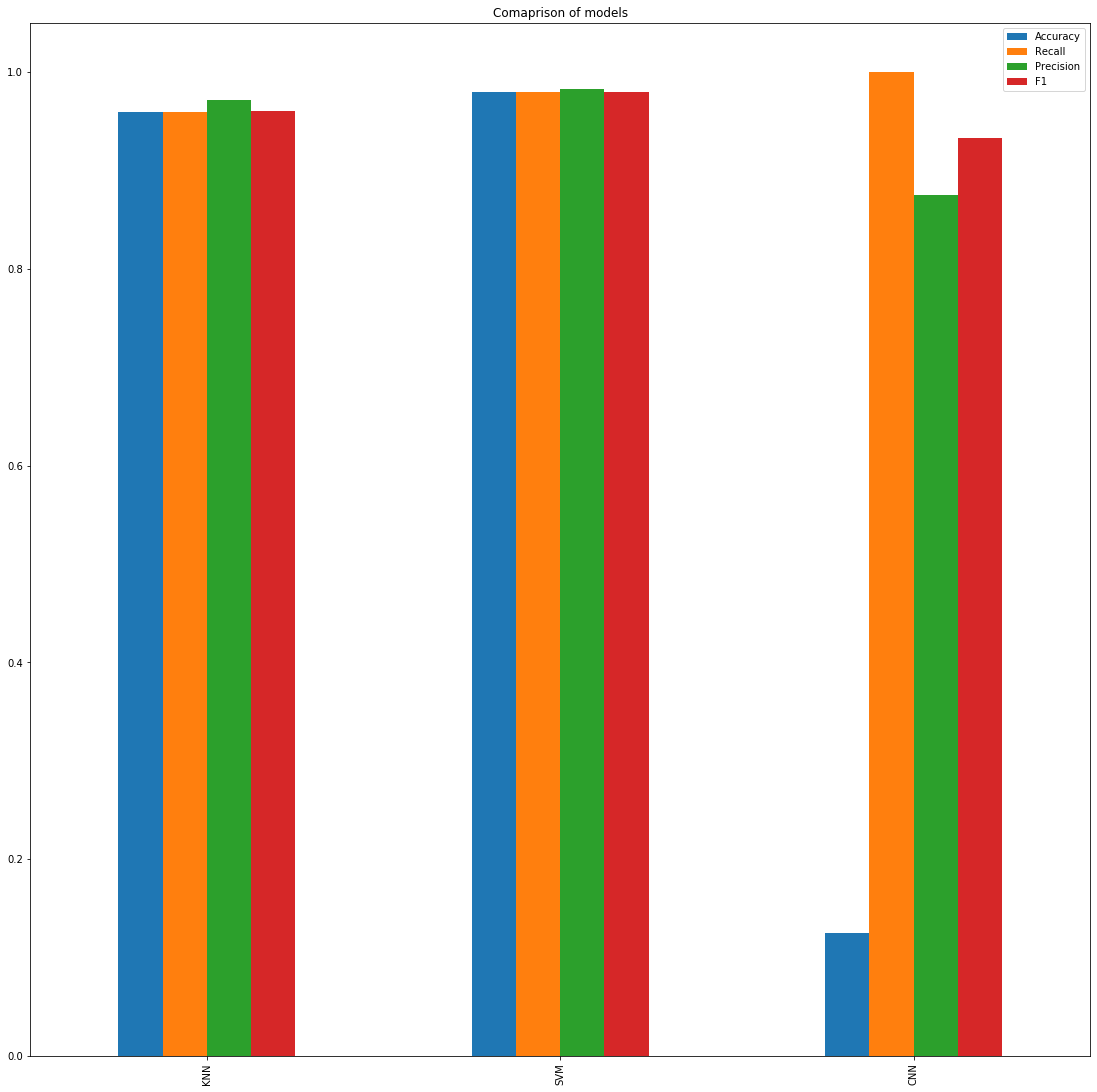

In [24]:
fig =results.plot(kind='bar',title='Comaprison of models',figsize =(19,19)).get_figure()
fig.savefig('Final Result.png')

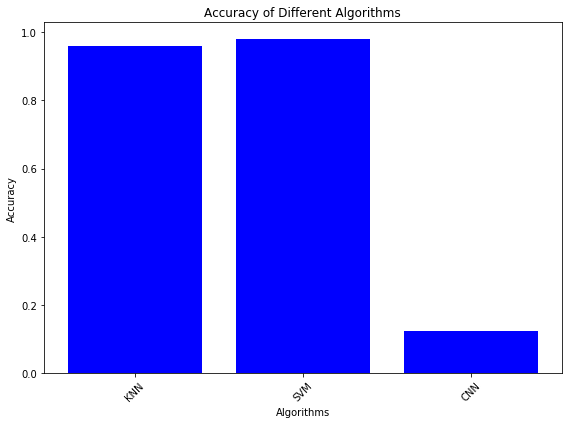

In [25]:
accuracy_values = results['Accuracy']
accuracy_df = pd.DataFrame({'Algorithms': index, 'Accuracy': accuracy_values})

plt.figure(figsize=(8, 6))
plt.bar(accuracy_df['Algorithms'], accuracy_df['Accuracy'], color='blue')
plt.title('Accuracy of Different Algorithms')
plt.xlabel('Algorithms')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

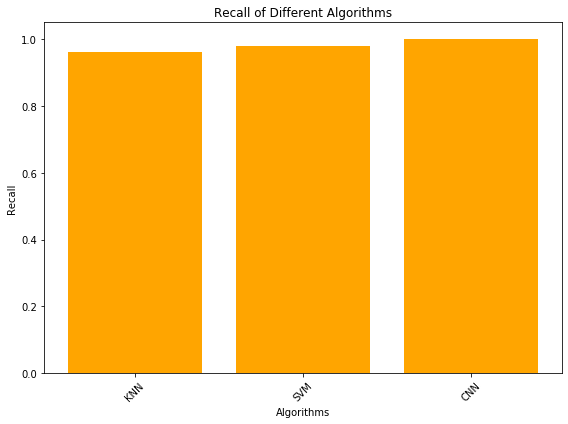

In [26]:
recall_values = results['Recall']
recall_df = pd.DataFrame({'Algorithms': index, 'Recall': recall_values})

plt.figure(figsize=(8, 6))
plt.bar(recall_df['Algorithms'], recall_df['Recall'], color='orange')
plt.title('Recall of Different Algorithms')
plt.xlabel('Algorithms')
plt.ylabel('Recall')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

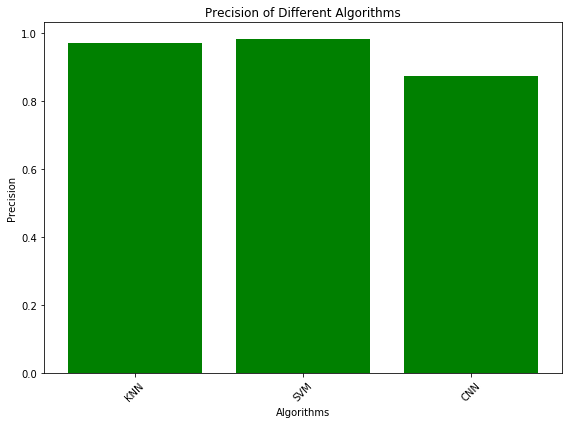

In [27]:
precision_values = results['Precision']
precision_df = pd.DataFrame({'Algorithms': index, 'Precision': precision_values})

plt.figure(figsize=(8, 6))
plt.bar(precision_df['Algorithms'], precision_df['Precision'], color='green')
plt.title('Precision of Different Algorithms')
plt.xlabel('Algorithms')
plt.ylabel('Precision')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

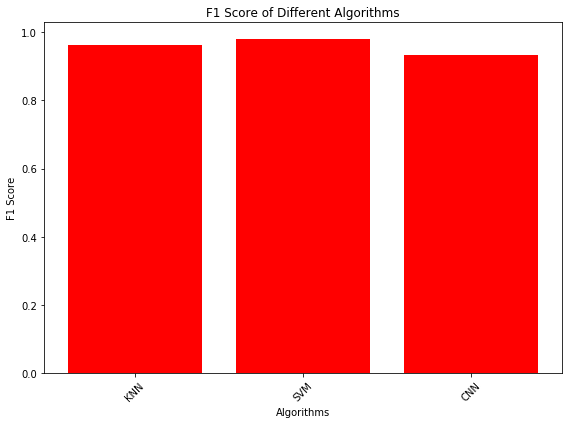

In [28]:
f1_values = results['F1']
f1_df = pd.DataFrame({'Algorithms': index, 'F1 Score': f1_values})

plt.figure(figsize=(8, 6))
plt.bar(f1_df['Algorithms'], f1_df['F1 Score'], color='red')
plt.title('F1 Score of Different Algorithms')
plt.xlabel('Algorithms')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Saving the model

In [29]:
pickle.dump(svc,open('model.pkl','wb'))